# HW 2 RNN & CNN on SNLI and MNLI Dataset    -- Lu Yin    DS 1011

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import matplotlib.pyplot as plt

In [4]:
max_word_load = 60000

# with open('wiki.en.vec') as en_model:
with open('wiki-news-300d-1M.vec') as en_model:

    pretrained_matrix = np.zeros((max_word_load+2, 300))
    words = {}
    word2idx = {}
    idx2word = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    
    pretrained_matrix[0,:] = np.zeros(300) # pad_vector
    pretrained_matrix[1,:] = np.random.normal(size = 300) #unk vector


    for i, words in enumerate(en_model):
        if i >= max_word_load:
            break
        s = words.split()
        pretrained_matrix[i+2, :] = np.asarray(s[1:])
        word2idx[s[0]] = i+2
        idx2word[i+2] = s[0]
    

# matrix_len = len(words)
# 
# for i, word in enumerate(words):
#     pretrained_matrix[i] = en_model[word]

# pretrained_matrix = torch.FloatTensor(pretrained_matrix)

In [135]:
#convert word to idx
PAD_IDX = 0
UNK_IDX = 1
MAX_SENTENCE_LENGTH = 30

def convert_to_idx(word_list):
    return [word2idx[word] if word in word2idx.keys() else UNK_IDX for word in word_list]

def tokenize(sent):
    return sent.split()

# data processing and input creation
def data_processing(data):
    output = []  
    data.loc[data.label == 'contradiction', 'label'] = 0
    data.loc[data.label == 'neutral', 'label'] = 1
    data.loc[data.label == 'entailment', 'label'] = 2
    s1, s2, label = data['sentence1'].values.tolist(), data['sentence2'].values.tolist(), data['label'].values.tolist()
    
    for i in range(len(s1)):
        list_s1 = convert_to_idx(tokenize(s1[i]))
        list_s2 = convert_to_idx(tokenize(s2[i]))
        temp_list = (list_s1, list_s2, label[i])
        output.append(temp_list)     
    return output

In [6]:
snli_train = pd.read_csv('snli_train.tsv',delimiter='\t',encoding='utf-8')
snli_val = pd.read_csv('snli_val.tsv',delimiter='\t',encoding='utf-8')

In [7]:
train_dataset = data_processing(snli_train)
val_dataset = data_processing(snli_val)

## DataLoader

In [8]:
# build DataLoader
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data):

        self.s1_list, self.s2_list, self.label_list = zip(*data)
        assert (len(self.s1_list) == len(self.label_list))
        assert (len(self.s2_list) == len(self.label_list))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        word_idx1 = self.s1_list[key][:MAX_SENTENCE_LENGTH]
        word_idx2 = self.s2_list[key][:MAX_SENTENCE_LENGTH]
        label = self.label_list[key]
        return [word_idx1, word_idx2, len(word_idx1), len(word_idx2), label]


def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list_s1 = [] #data sentence 1
    data_list_s2 = [] #data sentence 2
    label_list = []
    length_list_s1 = []
    length_list_s2 = []
    
    for datum in batch:
        label_list.append(datum[4])
        length_list_s1.append(datum[2])
        length_list_s2.append(datum[3])
        
    # padding
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_s1)
        data_list_s2.append(padded_vec_s2)
        
#     if torch.cuda.is_available and torch.has_cudnn:
#         return [torch.from_numpy(np.array(data_list_s1)).cuda(), torch.from_numpy(np.array(data_list_s2)).cuda(), torch.LongTensor(length_list_s1).cuda(), torch.LongTensor(length_list_s2).cuda(), torch.LongTensor(label_list).cuda()]
#     else:
    return [torch.from_numpy(np.array(data_list_s1)), torch.from_numpy(np.array(data_list_s2)), torch.LongTensor(length_list_s1), torch.LongTensor(length_list_s2), torch.LongTensor(label_list)]

In [9]:
BATCH_SIZE = 32

train_dataset = VocabDataset(train_dataset)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_dataset)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

## RNN model 

In [126]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, linear_size, dropout_p, num_classes):
        
        super(RNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pretrained_matrix).float(), freeze=True)
        self.bi_gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first = False, dropout = dropout_p, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size*2, linear_size)
        self.linear2 = nn.Linear(linear_size, num_classes)
        
    def init_hidden(self, batch_size):
        
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden

    def forward(self, x1,x2, length_s1, length_s2):
        # reset hidden state

        batch_size, seq_len_s1 = x1.size()
        _, seq_len_s2 = x2.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        
        #get the sort and  unsort index
        _, idx_sort1 = torch.sort(length_s1, dim = 0, descending = True)
        _, idx_unsort1 = torch.sort(idx_sort1, dim = 0)
        _, idx_sort2 = torch .sort(length_s2, dim = 0, descending = True)
        _, idx_unsort2 = torch.sort(idx_sort2, dim = 0)

        # get embedding of characters
        embed_s1 = self.embedding(x1)
        embed_s2 = self.embedding(x2)
        
        # sort embedding
        embed_s1 = embed_s1.index_select(0, idx_sort1)
        sort_length1 = length_s1[idx_sort1]
        
        embed_s2 = embed_s2.index_select(0, idx_sort2)
        sort_length2 = length_s2[idx_sort2]
        
        
        # pack padded sequence
        if torch.cuda.is_available and torch.has_cudnn:
            embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, sort_length1.cpu().numpy(), batch_first=True)
            embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, sort_length2.cpu().numpy(), batch_first=True)
        else:
            embed_s1 = torch.nn.utils.rnn.pack_padded_sequence(embed_s1, sort_length1.numpy(), batch_first=True)
            embed_s2 = torch.nn.utils.rnn.pack_padded_sequence(embed_s2, sort_length2.numpy(), batch_first=True)
            
        # fprop though GRU
        rnn_out1, self.hidden1 = self.bi_gru(embed_s1, self.hidden1)
        rnn_out2, self.hidden2 = self.bi_gru(embed_s2, self.hidden2)
        
#         #unpack:
#         rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
#         rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        
        #last layer of hidden states
        rnn_out1 = self.hidden1.cpu()[-1,:,:]
        rnn_out1 = torch.sum(self.hidden1,dim = 0)
        
        rnn_out2 = self.hidden2.cpu()[-1,:,:]
        rnn_out2 = torch.sum(self.hidden2,dim = 0)
        
        output_s1 = rnn_out1.index_select(0,idx_unsort1)
        output_s2 = rnn_out2.index_select(0,idx_unsort2)
        
        # concatenate two layers together:
        rnn_output = torch.cat((output_s1,output_s2),1)
        rnn_output = self.linear1(rnn_output)
        rnn_output = F.relu(rnn_output)
        logits  = self.linear2(rnn_output)
        return logits


In [46]:
def test_model(loader, model_input):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model_input.eval()
    
    for data1, data2, length1, length2, labels in loader:
        batch1, batch2, length1_batch, length2_batch, labels_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model_input(batch1, batch2, length1_batch, length2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [47]:
def run_model(train_loader_input, val_loader_input, model_input, learning_rate, num_epochs, loss_criterion, optimizer, show = True):
    
    val_acc_l = []
    loss_list = []
    for epoch in range(num_epochs):
        for i, (data_s1, data_s2, length1, length2, labels) in enumerate(train_loader_input):
            model_input.train()
            optimizer.zero_grad()
            
            # FP
            outputs = model_input(data_s1, data_s2, length1, length2)
            loss = loss_criterion(outputs, labels)
            
            # BP
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            
            # validate every 100 iterations
            if i > 0 and i % 100== 0:
                val_acc = test_model(val_loader_input, model_input)
                val_acc_l.append(val_acc)
                if show:
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(epoch+1, num_epochs, i+1, len(train_loader_input), val_acc))
    return val_acc_l, loss_list 

#     test_acc = test_model(test_loader, model)
#     print ("After training for {} epochs".format(num_epochs))
#     print ("Val Acc {}".format(test_model(val_loader, model)))
#     print ("Test Acc {}".format(test_acc)) 

In [165]:
## RNN with no dropout
model_rnn_nodropout = RNN(emb_size=300, hidden_size= 200, num_layers = 1, linear_size =200, dropout_p = 1, num_classes=3)

learning_rate = 3e-4
num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_nodropout.parameters(), lr=learning_rate)

val_acc_rnn_nodrop, loss_l_rnn_nodrop = run_model(train_loader, val_loader, model_rnn_nodropout, learning_rate, num_epochs, criterion, optimizer, show = True)

/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: [1/5], Step: [101/3125], Validation Acc: 42.6
Epoch: [1/5], Step: [201/3125], Validation Acc: 43.6
Epoch: [1/5], Step: [301/3125], Validation Acc: 52.3
Epoch: [1/5], Step: [401/3125], Validation Acc: 52.6
Epoch: [1/5], Step: [501/3125], Validation Acc: 51.6
Epoch: [1/5], Step: [601/3125], Validation Acc: 56.6
Epoch: [1/5], Step: [701/3125], Validation Acc: 55.6
Epoch: [1/5], Step: [801/3125], Validation Acc: 55.5
Epoch: [1/5], Step: [901/3125], Validation Acc: 55.6
Epoch: [1/5], Step: [1001/3125], Validation Acc: 58.9
Epoch: [1/5], Step: [1101/3125], Validation Acc: 57.3
Epoch: [1/5], Step: [1201/3125], Validation Acc: 57.3
Epoch: [1/5], Step: [1301/3125], Validation Acc: 58.2
Epoch: [1/5], Step: [1401/3125], Validation Acc: 58.5
Epoch: [1/5], Step: [1501/3125], Validation Acc: 58.7
Epoch: [1/5], Step: [1601/3125], Validation Acc: 58.8
Epoch: [1/5], Step: [1701/3125], Validation Acc: 58.5
Epoch: [1/5], Step: [1801/3125], Validation Acc: 58.7
Epoch: [1/5], Step: [1901/3125], Vali

Epoch: [5/5], Step: [3001/3125], Validation Acc: 69.2
Epoch: [5/5], Step: [3101/3125], Validation Acc: 68.8


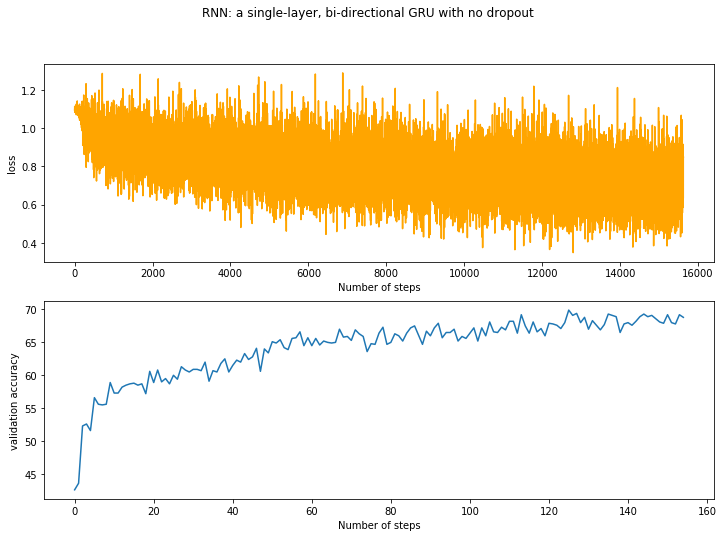

In [166]:
#RNN plot of loss and acc

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(211)
ax1.plot(loss_l_rnn_nodrop, color = 'orange')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('loss')

ax2 = plt.subplot(212)
ax2.plot(val_acc_rnn_nodrop)

ax2.set_xlabel('Number of steps')
ax2.set_ylabel('validation accuracy')

plt.suptitle('RNN: a single-layer, bi-directional GRU with no dropout')
plt.show()

In [73]:
# RNN dropout = 0.2
model_rnn = RNN(emb_size=300, hidden_size= 200, num_layers = 1, linear_size =200, dropout_p = 0.2, num_classes=3)

learning_rate = 3e-4
num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

val_acc_rnn, loss_l_rnn = run_model(train_loader, val_loader, model_rnn, learning_rate, num_epochs, criterion, optimizer, show = True)

/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: [1/5], Step: [101/3125], Validation Acc: 37.7
Epoch: [1/5], Step: [201/3125], Validation Acc: 46.2
Epoch: [1/5], Step: [301/3125], Validation Acc: 50.8
Epoch: [1/5], Step: [401/3125], Validation Acc: 52.9
Epoch: [1/5], Step: [501/3125], Validation Acc: 54.6
Epoch: [1/5], Step: [601/3125], Validation Acc: 56.7
Epoch: [1/5], Step: [701/3125], Validation Acc: 57.4
Epoch: [1/5], Step: [801/3125], Validation Acc: 57.3
Epoch: [1/5], Step: [901/3125], Validation Acc: 59.2
Epoch: [1/5], Step: [1001/3125], Validation Acc: 56.3
Epoch: [1/5], Step: [1101/3125], Validation Acc: 56.7
Epoch: [1/5], Step: [1201/3125], Validation Acc: 57.3
Epoch: [1/5], Step: [1301/3125], Validation Acc: 58.3
Epoch: [1/5], Step: [1401/3125], Validation Acc: 59.1
Epoch: [1/5], Step: [1501/3125], Validation Acc: 57.9
Epoch: [1/5], Step: [1601/3125], Validation Acc: 59.2
Epoch: [1/5], Step: [1701/3125], Validation Acc: 57.0
Epoch: [1/5], Step: [1801/3125], Validation Acc: 59.8
Epoch: [1/5], Step: [1901/3125], Vali

Epoch: [5/5], Step: [3001/3125], Validation Acc: 69.3
Epoch: [5/5], Step: [3101/3125], Validation Acc: 69.1


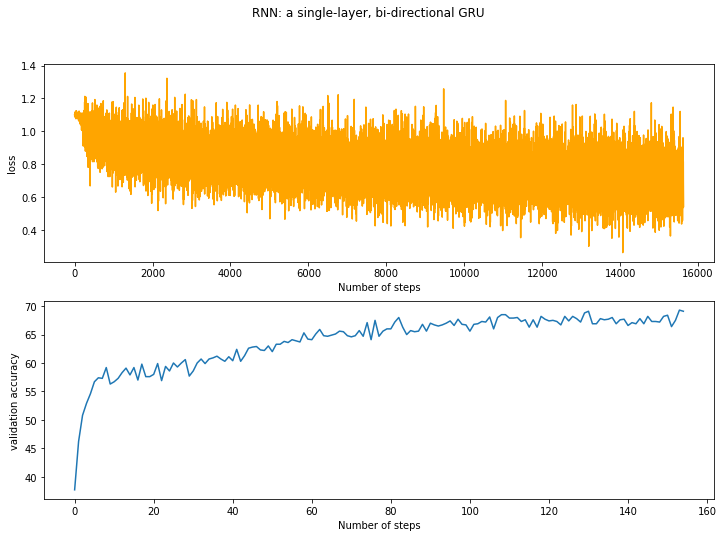

In [80]:
#RNN plot of loss and acc

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(211)
ax1.plot(loss_l_rnn, color = 'orange')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('loss')

ax2 = plt.subplot(212)
ax2.plot(val_acc_rnn)

ax2.set_xlabel('Number of steps')
ax2.set_ylabel('validation accuracy')

plt.suptitle('RNN: a single-layer, bi-directional GRU')
plt.show()

In [170]:
# RNN dropout = 0.5
model_rnn_drop = RNN(emb_size=300, hidden_size= 200, num_layers = 1, linear_size =200, dropout_p = 0.5, num_classes=3)

learning_rate = 3e-4
num_epochs = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_drop.parameters(), lr=learning_rate)

val_acc_rnn_drop, loss_l_rnn_drop = run_model(train_loader, val_loader, model_rnn_drop, learning_rate, num_epochs, criterion, optimizer, show = True)

Epoch: [1/5], Step: [101/3125], Validation Acc: 36.9
Epoch: [1/5], Step: [201/3125], Validation Acc: 42.7
Epoch: [1/5], Step: [301/3125], Validation Acc: 53.1
Epoch: [1/5], Step: [401/3125], Validation Acc: 52.5
Epoch: [1/5], Step: [501/3125], Validation Acc: 55.2
Epoch: [1/5], Step: [601/3125], Validation Acc: 56.4
Epoch: [1/5], Step: [701/3125], Validation Acc: 58.0
Epoch: [1/5], Step: [801/3125], Validation Acc: 55.4
Epoch: [1/5], Step: [901/3125], Validation Acc: 55.2
Epoch: [1/5], Step: [1001/3125], Validation Acc: 57.5
Epoch: [1/5], Step: [1101/3125], Validation Acc: 58.0
Epoch: [1/5], Step: [1201/3125], Validation Acc: 56.8
Epoch: [1/5], Step: [1301/3125], Validation Acc: 59.3
Epoch: [1/5], Step: [1401/3125], Validation Acc: 59.7
Epoch: [1/5], Step: [1501/3125], Validation Acc: 58.2
Epoch: [1/5], Step: [1601/3125], Validation Acc: 57.4
Epoch: [1/5], Step: [1701/3125], Validation Acc: 59.4
Epoch: [1/5], Step: [1801/3125], Validation Acc: 60.3
Epoch: [1/5], Step: [1901/3125], Vali

Epoch: [5/5], Step: [3001/3125], Validation Acc: 69.5
Epoch: [5/5], Step: [3101/3125], Validation Acc: 68.2


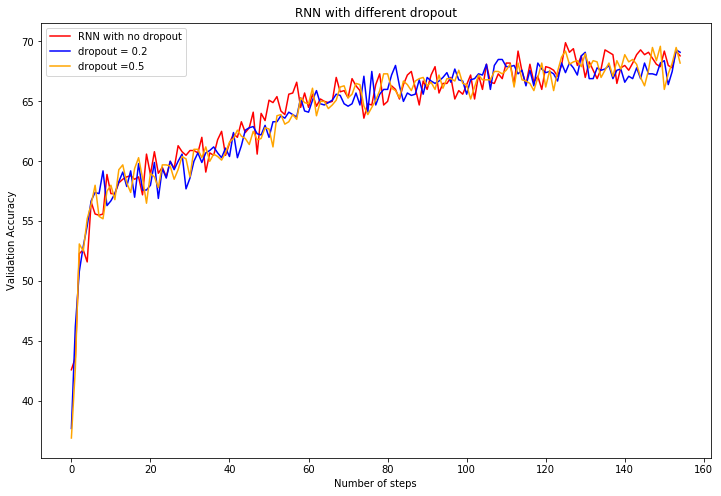

In [178]:
plt.figure(figsize=(12, 8))

# ax1 = plt.subplot(211)
# ax1.plot(loss_l_rnn, color = 'blue', label = 'dropout = 0.2')
# ax1.plot(loss_l_rnn_nodrop, color = 'red', label = 'RNN with no dropout')
# ax1.plot(loss_l_rnn_drop, color = 'orange', label = 'dropout =0.5')
# ax1.set_xlabel('Number of steps')
# ax1.set_ylabel('loss')

# ax2 = plt.subplot(212)
# ax2.plot(val_acc_rnn, color = 'blue', label = 'dropout = 0.2')
# ax2.plot(val_acc_rnn_nodrop, color = 'red', label = 'RNN with no dropout')
# ax2.plot(val_acc_rnn_drop, color = 'orange', label = 'dropout = 0.5')

# ax2.set_xlabel('Number of steps')
# ax2.set_ylabel('validation accuracy')

plt.plot(val_acc_rnn_nodrop, color = 'red', label = 'RNN with no dropout')
plt.plot(val_acc_rnn, color = 'blue', label = 'dropout = 0.2')
plt.plot(val_acc_rnn_drop, color = 'orange', label = 'dropout =0.5')
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.title('RNN with different dropout')
plt.legend()
plt.show()

In [163]:
learning_rate = 3e-4
num_epochs = 1
criterion = torch.nn.CrossEntropyLoss()

rnn_hidden_loss_list = []
rnn_hidden_val_acc= []
rnn_hidden_size_list= [50, 100, 200, 300]

for h_size in hidden_size_list:
    #holding other parameters constant
    model_rnn_1 = RNN(emb_size=300, hidden_size= h_size, num_layers = 1, linear_size =200, dropout_p = 0.2, num_classes=3)
    optimizer = torch.optim.Adam(model_rnn_1.parameters(), lr=learning_rate)
    val_acc, loss_l = run_model(train_loader, val_loader, model_rnn_1, learning_rate, num_epochs, criterion, optimizer, show = True)
    
    rnn_hidden_loss_list.append(loss_l)
    rnn_hidden_val_acc.append(val_acc)

Epoch: [1/1], Step: [101/3125], Validation Acc: 36.2
Epoch: [1/1], Step: [201/3125], Validation Acc: 41.7
Epoch: [1/1], Step: [301/3125], Validation Acc: 42.9
Epoch: [1/1], Step: [401/3125], Validation Acc: 49.9
Epoch: [1/1], Step: [501/3125], Validation Acc: 51.3
Epoch: [1/1], Step: [601/3125], Validation Acc: 50.1
Epoch: [1/1], Step: [701/3125], Validation Acc: 53.7
Epoch: [1/1], Step: [801/3125], Validation Acc: 54.2
Epoch: [1/1], Step: [901/3125], Validation Acc: 56.3
Epoch: [1/1], Step: [1001/3125], Validation Acc: 54.7
Epoch: [1/1], Step: [1101/3125], Validation Acc: 53.3
Epoch: [1/1], Step: [1201/3125], Validation Acc: 54.8
Epoch: [1/1], Step: [1301/3125], Validation Acc: 57.0
Epoch: [1/1], Step: [1401/3125], Validation Acc: 56.1
Epoch: [1/1], Step: [1501/3125], Validation Acc: 56.5
Epoch: [1/1], Step: [1601/3125], Validation Acc: 57.1
Epoch: [1/1], Step: [1701/3125], Validation Acc: 57.3
Epoch: [1/1], Step: [1801/3125], Validation Acc: 56.7
Epoch: [1/1], Step: [1901/3125], Vali

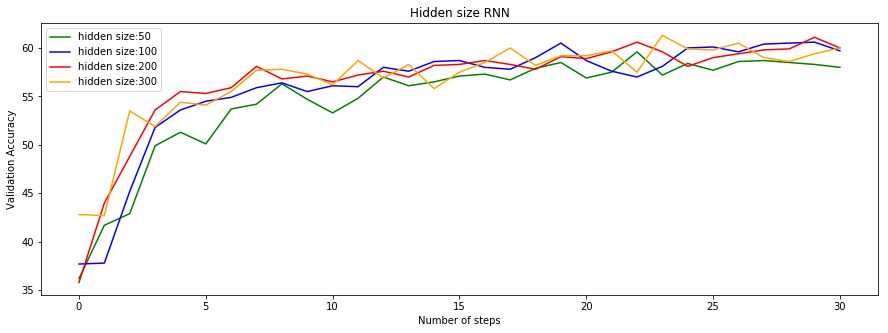

In [177]:
# plt.axis('equal')
color_l = ['green', 'blue', 'red', 'orange']
plt.figure(figsize=(15, 5))
for i in range(len(rnn_hidden_val_acc)):
    plt.plot(rnn_hidden_val_acc[i], color = color_l[i], label= 'hidden size:'+ str(rnn_hidden_size_list[i]))
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.title('Hidden size RNN')
plt.legend()
plt.show()    

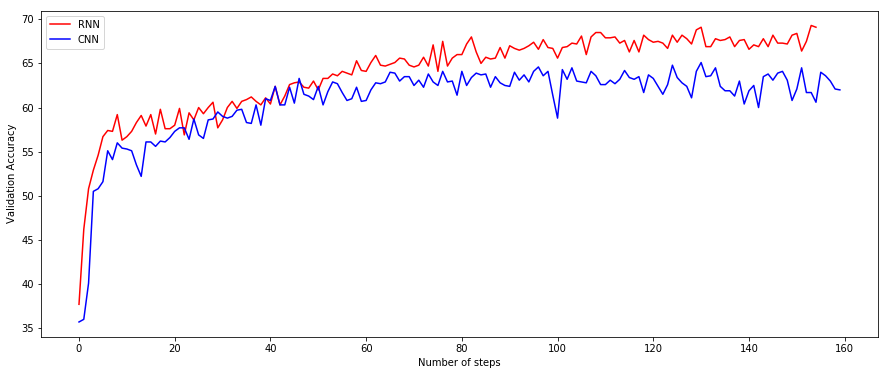

In [83]:
plt.figure(figsize=(15, 6))
plt.plot(val_acc_rnn, color = 'red', label = 'RNN')
plt.plot(cnn_val_acc_list[:160], color = 'blue', label = 'CNN')
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.title('compare basine line RNN & CNN')
plt.legend()
plt.show()

## CNN model

In [14]:
class CNN(nn.Module):
    
    def __init__(self, emb_size, hidden_size, linear_size, kernel_size, num_classes):

        super(CNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pretrained_matrix).float(), freeze=True)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size, padding=0)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size, padding=0)
        self.linear1 = nn.Linear(hidden_size, linear_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x1, x2, length1, length2):
        
        batch_size, seq_len1 = x1.size()
        _, seq_len2 = x2.size()

        embed_s1 = self.embedding(x1)
        hidden1 = self.conv1(embed_s1.transpose(1,2)).transpose(1, 2)
        hidden1 = F.relu(hidden1)
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1)
        
        embed_s2 = self.embedding(x2)
        hidden2 = self.conv1(embed_s2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2)
        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2)

        hidden3 = torch.cat((hidden1, hidden2), 1) #dim = 1
        hidden3 = torch.max(hidden3, 1)[0] #dim = 1
        
        hidden3 = self.linear1(hidden3)
        hidden3 = F.relu(hidden3)
        logits = self.linear2(hidden3)
        
        return logits


In [87]:
model = CNN(emb_size=300, hidden_size=200, linear_size =200, kernel_size=3, num_classes=3)

learning_rate = 3e-4
num_epochs = 10

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cnn_loss_list = []
cnn_val_acc_list = []

for epoch in range(num_epochs):
    for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        # FP
        outputs = model(data1, data2, length1, length2)
        loss = criterion(outputs, labels)
        
        # BP
        loss.backward()
        optimizer.step()
        cnn_loss_list.append(loss.item())
        
        if i > 0 and i % 100 == 0:
            # validation
            val_acc = test_model(val_loader, model)
            cnn_val_acc_list.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

Epoch: [1/10], Step: [101/3125], Validation Acc: 35.7
Epoch: [1/10], Step: [201/3125], Validation Acc: 34.6
Epoch: [1/10], Step: [301/3125], Validation Acc: 41.7
Epoch: [1/10], Step: [401/3125], Validation Acc: 44.5
Epoch: [1/10], Step: [501/3125], Validation Acc: 50.6
Epoch: [1/10], Step: [601/3125], Validation Acc: 52.2
Epoch: [1/10], Step: [701/3125], Validation Acc: 50.5
Epoch: [1/10], Step: [801/3125], Validation Acc: 51.8
Epoch: [1/10], Step: [901/3125], Validation Acc: 53.0
Epoch: [1/10], Step: [1001/3125], Validation Acc: 55.5
Epoch: [1/10], Step: [1101/3125], Validation Acc: 54.7
Epoch: [1/10], Step: [1201/3125], Validation Acc: 55.5
Epoch: [1/10], Step: [1301/3125], Validation Acc: 54.7
Epoch: [1/10], Step: [1401/3125], Validation Acc: 54.4
Epoch: [1/10], Step: [1501/3125], Validation Acc: 56.7
Epoch: [1/10], Step: [1601/3125], Validation Acc: 55.7
Epoch: [1/10], Step: [1701/3125], Validation Acc: 54.9
Epoch: [1/10], Step: [1801/3125], Validation Acc: 53.5
Epoch: [1/10], Step

Epoch: [5/10], Step: [2701/3125], Validation Acc: 61.9
Epoch: [5/10], Step: [2801/3125], Validation Acc: 61.3
Epoch: [5/10], Step: [2901/3125], Validation Acc: 61.8
Epoch: [5/10], Step: [3001/3125], Validation Acc: 61.8
Epoch: [5/10], Step: [3101/3125], Validation Acc: 63.7
Epoch: [6/10], Step: [101/3125], Validation Acc: 64.1
Epoch: [6/10], Step: [201/3125], Validation Acc: 62.4
Epoch: [6/10], Step: [301/3125], Validation Acc: 62.7
Epoch: [6/10], Step: [401/3125], Validation Acc: 63.1
Epoch: [6/10], Step: [501/3125], Validation Acc: 62.7
Epoch: [6/10], Step: [601/3125], Validation Acc: 62.7
Epoch: [6/10], Step: [701/3125], Validation Acc: 61.5
Epoch: [6/10], Step: [801/3125], Validation Acc: 63.9
Epoch: [6/10], Step: [901/3125], Validation Acc: 64.1
Epoch: [6/10], Step: [1001/3125], Validation Acc: 63.2
Epoch: [6/10], Step: [1101/3125], Validation Acc: 62.8
Epoch: [6/10], Step: [1201/3125], Validation Acc: 63.1
Epoch: [6/10], Step: [1301/3125], Validation Acc: 62.1
Epoch: [6/10], Step

Epoch: [10/10], Step: [2201/3125], Validation Acc: 61.8
Epoch: [10/10], Step: [2301/3125], Validation Acc: 60.6
Epoch: [10/10], Step: [2401/3125], Validation Acc: 59.8
Epoch: [10/10], Step: [2501/3125], Validation Acc: 62.4
Epoch: [10/10], Step: [2601/3125], Validation Acc: 60.3
Epoch: [10/10], Step: [2701/3125], Validation Acc: 60.2
Epoch: [10/10], Step: [2801/3125], Validation Acc: 60.1
Epoch: [10/10], Step: [2901/3125], Validation Acc: 61.0
Epoch: [10/10], Step: [3001/3125], Validation Acc: 61.0
Epoch: [10/10], Step: [3101/3125], Validation Acc: 61.5


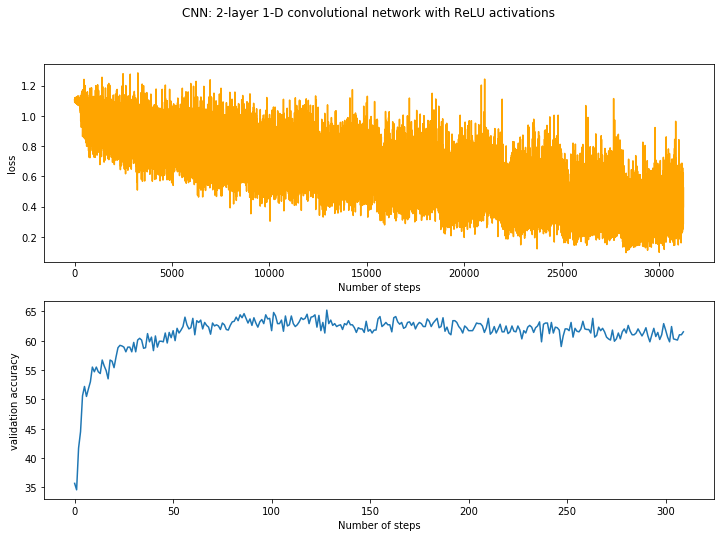

In [88]:
#CNN plot of loss and acc

plt.figure(figsize=(12, 8))

ax1 = plt.subplot(211)
ax1.plot(cnn_loss_list, color = 'orange')
ax1.set_xlabel('Number of steps')
ax1.set_ylabel('loss')

ax2 = plt.subplot(212)
ax2.plot(cnn_val_acc_list)

ax2.set_xlabel('Number of steps')
ax2.set_ylabel('validation accuracy')

plt.suptitle('CNN: 2-layer 1-D convolutional network with ReLU activations')
plt.show()

## Exploration on hidden dimension of CNN

In [68]:
learning_rate = 3e-4
num_epochs = 1
criterion = torch.nn.CrossEntropyLoss()

hidden_loss_list = []
hidden_val_acc= []
hidden_size_list= [50, 100, 200, 300]

for h_size in hidden_size_list:
    #holding other parameters constant
    model_1 = CNN(emb_size=300, hidden_size= h_size, linear_size =h_size, kernel_size=3, num_classes=3)
    optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
    val_acc, loss_l = run_model(train_loader, val_loader, model_1, learning_rate, num_epochs, criterion, optimizer, show = True)
    
    hidden_loss_list.append(loss_l)
    hidden_val_acc.append(val_acc)

Epoch: [1/1], Step: [101/3125], Validation Acc: 36.9
Epoch: [1/1], Step: [201/3125], Validation Acc: 36.5
Epoch: [1/1], Step: [301/3125], Validation Acc: 42.2
Epoch: [1/1], Step: [401/3125], Validation Acc: 39.3
Epoch: [1/1], Step: [501/3125], Validation Acc: 36.7
Epoch: [1/1], Step: [601/3125], Validation Acc: 45.1
Epoch: [1/1], Step: [701/3125], Validation Acc: 49.2
Epoch: [1/1], Step: [801/3125], Validation Acc: 51.6
Epoch: [1/1], Step: [901/3125], Validation Acc: 50.7
Epoch: [1/1], Step: [1001/3125], Validation Acc: 51.6
Epoch: [1/1], Step: [1101/3125], Validation Acc: 53.3
Epoch: [1/1], Step: [1201/3125], Validation Acc: 51.7
Epoch: [1/1], Step: [1301/3125], Validation Acc: 52.1
Epoch: [1/1], Step: [1401/3125], Validation Acc: 53.2
Epoch: [1/1], Step: [1501/3125], Validation Acc: 53.1
Epoch: [1/1], Step: [1601/3125], Validation Acc: 52.7
Epoch: [1/1], Step: [1701/3125], Validation Acc: 54.0
Epoch: [1/1], Step: [1801/3125], Validation Acc: 54.1
Epoch: [1/1], Step: [1901/3125], Vali

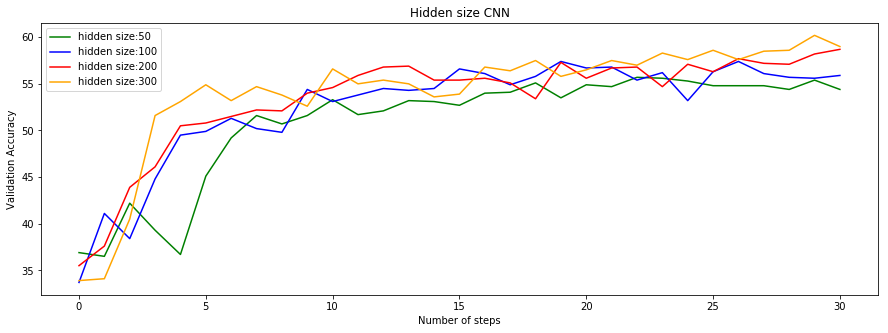

In [180]:
# plt.axis('equal')
color_l = ['green', 'blue', 'red', 'orange']
plt.figure(figsize=(15, 5))
for i in range(len(hidden_val_acc)):
    plt.plot(hidden_val_acc[i], color = color_l[i], label= 'hidden size:'+ str(hidden_size_list[i]))
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.title('Hidden size CNN')
plt.legend()
plt.show()    

## Exploration on kernel size

In [70]:
learning_rate = 3e-4
num_epochs = 1

criterion = torch.nn.CrossEntropyLoss()

kernel_loss_list = []
kernel_val_acc= []
kernel_size_list= [2, 3, 4, 5]

for k_size in kernel_size_list:
    #holding other parameters constant
    
    model_2 = CNN(emb_size=300, hidden_size= 200, linear_size = 200, kernel_size= k_size, num_classes=3)
    optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
    val_acc, loss_l = run_model(train_loader, val_loader, model_2, learning_rate, num_epochs, criterion, optimizer, show = True)
    
    kernel_loss_list.append(loss_l)
    kernel_val_acc.append(val_acc)

Epoch: [1/1], Step: [101/3125], Validation Acc: 35.4
Epoch: [1/1], Step: [201/3125], Validation Acc: 35.7
Epoch: [1/1], Step: [301/3125], Validation Acc: 41.1
Epoch: [1/1], Step: [401/3125], Validation Acc: 45.8
Epoch: [1/1], Step: [501/3125], Validation Acc: 46.6
Epoch: [1/1], Step: [601/3125], Validation Acc: 50.3
Epoch: [1/1], Step: [701/3125], Validation Acc: 50.6
Epoch: [1/1], Step: [801/3125], Validation Acc: 54.6
Epoch: [1/1], Step: [901/3125], Validation Acc: 52.6
Epoch: [1/1], Step: [1001/3125], Validation Acc: 52.3
Epoch: [1/1], Step: [1101/3125], Validation Acc: 52.9
Epoch: [1/1], Step: [1201/3125], Validation Acc: 56.1
Epoch: [1/1], Step: [1301/3125], Validation Acc: 55.5
Epoch: [1/1], Step: [1401/3125], Validation Acc: 56.8
Epoch: [1/1], Step: [1501/3125], Validation Acc: 56.6
Epoch: [1/1], Step: [1601/3125], Validation Acc: 57.5
Epoch: [1/1], Step: [1701/3125], Validation Acc: 56.7
Epoch: [1/1], Step: [1801/3125], Validation Acc: 58.5
Epoch: [1/1], Step: [1901/3125], Vali

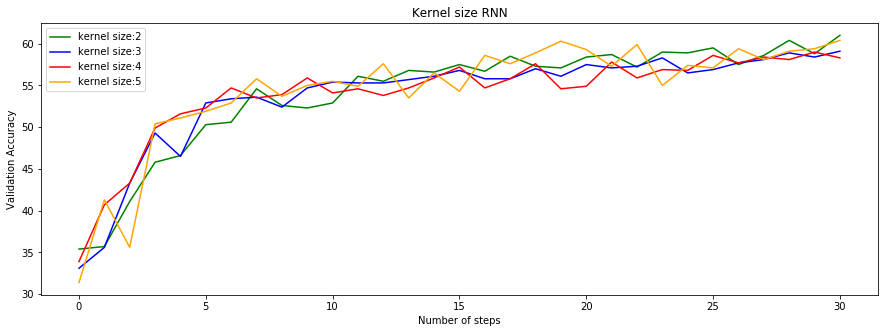

In [182]:
color_l = ['green', 'blue', 'red', 'orange']
plt.figure(figsize=(15, 5))
for i in range(len(kernel_val_acc)):
    plt.plot(kernel_val_acc[i], color = color_l[i], label='kernel size:'+ str(kernel_size_list[i]))
plt.xlabel("Number of steps")
plt.ylabel("Validation Accuracy")
plt.title('Kernel size RNN')
plt.legend()
plt.show()  

In [183]:
# CNN with kernel size 3 and hidden size 300
model_cnn_final = CNN(emb_size=300, hidden_size= 300, linear_size =300, kernel_size=3, num_classes=3)

learning_rate = 3e-4
num_epochs = 4

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_final.parameters(), lr=learning_rate)

val_acc_cnn_final, loss_l_cnn_final = run_model(train_loader, val_loader, model_cnn_final, learning_rate, num_epochs, criterion, optimizer, show = True)

Epoch: [1/6], Step: [101/3125], Validation Acc: 33.1
Epoch: [1/6], Step: [201/3125], Validation Acc: 41.1
Epoch: [1/6], Step: [301/3125], Validation Acc: 45.6
Epoch: [1/6], Step: [401/3125], Validation Acc: 49.0
Epoch: [1/6], Step: [501/3125], Validation Acc: 51.1
Epoch: [1/6], Step: [601/3125], Validation Acc: 53.5
Epoch: [1/6], Step: [701/3125], Validation Acc: 55.4
Epoch: [1/6], Step: [801/3125], Validation Acc: 53.1
Epoch: [1/6], Step: [901/3125], Validation Acc: 56.1
Epoch: [1/6], Step: [1001/3125], Validation Acc: 55.3
Epoch: [1/6], Step: [1101/3125], Validation Acc: 56.5
Epoch: [1/6], Step: [1201/3125], Validation Acc: 55.8
Epoch: [1/6], Step: [1301/3125], Validation Acc: 56.5
Epoch: [1/6], Step: [1401/3125], Validation Acc: 56.3
Epoch: [1/6], Step: [1501/3125], Validation Acc: 57.9
Epoch: [1/6], Step: [1601/3125], Validation Acc: 57.1
Epoch: [1/6], Step: [1701/3125], Validation Acc: 57.2
Epoch: [1/6], Step: [1801/3125], Validation Acc: 58.3
Epoch: [1/6], Step: [1901/3125], Vali

Epoch: [5/6], Step: [3001/3125], Validation Acc: 63.9
Epoch: [5/6], Step: [3101/3125], Validation Acc: 62.9
Epoch: [6/6], Step: [101/3125], Validation Acc: 64.5
Epoch: [6/6], Step: [201/3125], Validation Acc: 63.2
Epoch: [6/6], Step: [301/3125], Validation Acc: 63.1
Epoch: [6/6], Step: [401/3125], Validation Acc: 62.8
Epoch: [6/6], Step: [501/3125], Validation Acc: 62.2
Epoch: [6/6], Step: [601/3125], Validation Acc: 63.2
Epoch: [6/6], Step: [701/3125], Validation Acc: 62.5
Epoch: [6/6], Step: [801/3125], Validation Acc: 62.6
Epoch: [6/6], Step: [901/3125], Validation Acc: 63.7
Epoch: [6/6], Step: [1001/3125], Validation Acc: 63.6
Epoch: [6/6], Step: [1101/3125], Validation Acc: 62.7
Epoch: [6/6], Step: [1201/3125], Validation Acc: 64.5
Epoch: [6/6], Step: [1301/3125], Validation Acc: 64.1
Epoch: [6/6], Step: [1401/3125], Validation Acc: 62.3
Epoch: [6/6], Step: [1501/3125], Validation Acc: 63.0
Epoch: [6/6], Step: [1601/3125], Validation Acc: 63.5
Epoch: [6/6], Step: [1701/3125], Vali

## Take right and wrong results

In [109]:
def test_result_selection(loader_input, model):
    right_count = 0
    wrong_count = 0
    
    right_l = []
    wrong_l = []
    model.eval()
    
    for data1, data2, length1, length2, labels in loader_input:
            
        outputs = F.softmax(model(data1, data2, length1, length2), 1)
        predicted = outputs.max(1, keepdim=True)[1]
        result = predicted.eq(labels.view_as(predicted)).cpu().numpy()
#         print(result)
        for i, boolean_result in enumerate(result):
            if boolean_result  == 0: # 0 when it is a wrong conclusion
                wrong_l.append([data1[i], data2[i], labels[i], predicted[i]])
                wrong_count+=1 
    
            else:  # else 1 when it is a right conclusion 
                right_l.append([data1[i], data2[i], labels[i], predicted[i]])
                right_count+=1
        if right_count >= 4 and wrong_count >=4: #sample 4 for each situation
            break
            
    return right_l, wrong_l

In [110]:
# model_rnn = RNN(emb_size=300, hidden_size= 200, num_layers = 1, linear_size =200, num_classes=3)

# learning_rate = 3e-4

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

# val_acc_rnn, loss_l_rnn = run_model(train_loader, val_loader, model_rnn, learning_rate, num_epochs = 5, criterion, optimizer, show = True)

In [111]:
right_l, wrong_l = test_result_selection(val_loader, model_rnn)
right_l_cnn, wrong_l_cnn = test_result_selection(val_loader, model_cnn_final)

In [113]:
def idx2sentence(idx_list):
    output = []
    for s1, s2, label, prediction in idx_list:
        list_s1 = s1.numpy() #change tensor back to numpy
        list_s2 = s2.numpy()
        label = label.numpy()
        prediction = prediction.numpy()
        sentence_1 = ' '.join([idx2word[s] for s in list_s1 if s > 1]) #screen out unk and pad for index
        sentence_2 = ' '.join([idx2word[s] for s in list_s2 if s > 1])
        if label == 0:
            label_result = 'contradiction'
        elif label == 1:
            label_result = 'netrual'
        elif label == 2:
            label_result = 'entailment'
        
        if prediction == 0:
            prediction_result = 'contradiction'
        elif prediction == 1:
            prediction_result = 'netrual'
        elif prediction == 2:
            prediction_result = 'entailment'
            
        output.append([sentence_1, sentence_2, label_result, prediction_result]) 
        
#     data.loc[data.label == 'contradiction', 'label'] = 0
#     data.loc[data.label == 'neutral', 'label'] = 1
#     data.loc[data.label == 'entailment', 'label'] = 2
    return output

In [114]:
idx2sentence(right_l)[0]

['Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor',
 'There are two women standing on the stage',
 'contradiction',
 'contradiction']

In [115]:
idx2sentence(right_l)[1]

['Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
 'Multiple people are on a subway together , with each of them doing their own thing .',
 'entailment',
 'entailment']

In [116]:
idx2sentence(right_l)[2]

['bicycles stationed while a group of people socialize .',
 'People get together near a stand of bicycles .',
 'entailment',
 'entailment']

In [117]:
idx2sentence(wrong_l)[0]

['Two people are in a green forest .',
 'The forest is not dead .',
 'entailment',
 'contradiction']

In [118]:
idx2sentence(wrong_l)[1]

['Two women , one walking her dog the other pushing a .',
 'There is a snowstorm .',
 'contradiction',
 'netrual']

In [136]:
idx2sentence(wrong_l)[2]

['A large group of people stand outside on a road while people on a higher level look on at them .',
 'One group of people are watching what another group does .',
 'entailment',
 'netrual']

# Evaluating on MultiNLI

In [120]:
MNLI_train = pd.read_csv('mnli_train.tsv',delimiter='\t',encoding='utf-8')
MNLI_val = pd.read_csv('mnli_val.tsv',delimiter='\t',encoding='utf-8')

In [121]:
MNLI_train.head(5)

,sentence1,sentence2,label,genre
0,and now that was in fifty one that 's forty ye...,It was already a problem forty years ago but n...,neutral,telephone
1,Jon could smell baked bread on the air and his...,Jon smelt food in the air and was hungry .,neutral,fiction
2,it will be like Italian basketball with the uh...,This type of Italian basketball is nothing lik...,contradiction,telephone
3,well i think that 's about uh that 's about co...,Sorry but we are not done just yet .,contradiction,telephone
4,"Good job tenure , that is -- because in yet an...","Dr. Quinn , Medicine Woman , was worked on by ...",entailment,slate


In [131]:
l_g = MNLI_train['genre'].unique()
l_g

array(['telephone', 'fiction', 'slate', 'government', 'travel'],
      dtype=object)

In [184]:
#evalutaion pipline:

dic_gen_rnn = {}
for genre in l_g:
    dataset = data_processing(MNLI_val.loc[MNLI_val['genre']  == genre])
    val_dataloader = torch.utils.data.DataLoader(dataset= VocabDataset(dataset),
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    val_acc_score = test_model(val_dataloader, model_rnn)
    dic_gen_rnn[genre] = val_acc_score

dic_gen_cnn = {}
for genre in l_g:
    dataset = data_processing(MNLI_val.loc[MNLI_val['genre']  == genre])
    val_dataloader = torch.utils.data.DataLoader(dataset= VocabDataset(dataset),
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)
    val_acc_score = test_model(val_dataloader, model_cnn_final) # cnn model
    dic_gen_cnn[genre] = val_acc_score
     

/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/luyin/anaconda3/envs/nlps/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [160]:
dic_gen_rnn

{'telephone': 43.18407960199005,
 'fiction': 45.62814070351759,
 'slate': 41.71656686626746,
 'government': 43.996062992125985,
 'travel': 44.70468431771894}

In [187]:
dic_gen_cnn.values()

[41.791044776119406,
 42.71356783919598,
 39.421157684630735,
 41.43700787401575,
 42.56619144602851]

In [ ]:
# dic_gen_cnn = {}
# for genre in l_g:
#     dataset = data_processing(MNLI_val.loc[MNLI_val['genre']  == genre])
#     val_dataloader = torch.utils.data.DataLoader(dataset= VocabDataset(dataset),
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)
#     val_acc_score = test_model(val_dataloader, model_cnn_final) # cnn model
#     dic_gen_cnn[genre] = val_acc_score

In [206]:
result_table = pd.DataFrame(list(zip(\
list(dic_gen_rnn.values()), list(dic_gen_cnn.values()))), columns = ['RNN', 'CNN'],\
index= ['Telephone', 'Fiction', 'Slate', 'Government', 'Travel'])

In [209]:
print('MNLI accuracy table:')
result_table

MNLI accuracy table:


,RNN,CNN
Telephone,43.184080,41.791045
Fiction,45.628141,42.713568
Slate,41.716567,39.421158
Government,43.996063,41.437008
Travel,44.704684,42.566191


In [146]:
# val_tele = MNLI_val.loc[MNLI_val['genre']  == 'telephone']
# val_fic = MNLI_val.loc[MNLI_val['genre']  == 'fiction']
# val_slate = MNLI_val.loc[MNLI_val['genre']  == 'slate']
# val_gov = MNLI_val.loc[MNLI_val['genre']  == 'government']
# val_tra = MNLI_val.loc[MNLI_val['genre']  == 'travel']

In [147]:
# val_tele_dataset = data_processing(val_tele)
# val_fic_dataset = data_processing(val_fic)
# val_slate_dataset = data_processing(val_slate)
# val_tra_dataset = data_processing(val_tra)
# val_gov_dataset = data_processing(val_gov)

In [148]:
# BATCH_SIZE = 32
# val_tele_dataset = VocabDataset(val_tele_dataset)
# val_tele_loader = torch.utils.data.DataLoader(dataset=val_tele_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)

# val_fic_dataset = VocabDataset(val_fic_dataset)
# val_fic_loader = torch.utils.data.DataLoader(dataset=val_fic_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)

# val_slate_dataset= VocabDataset(val_slate_dataset)
# val_slate_loader = torch.utils.data.DataLoader(dataset=val_slate_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)

# val_tra_dataset = VocabDataset(val_tra_dataset)
# val_tra_loader = torch.utils.data.DataLoader(dataset=val_tra_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)

# val_gov_dataset = VocabDataset(val_gov_dataset)
# val_gov_loader = torch.utils.data.DataLoader(dataset=val_gov_dataset,
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=vocab_collate_func,
#                                            shuffle=False)